### Modules

modified from `/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/04_interp/test_lstm_sbi1`

Script for aggregating information from multiple and different sbi runs

In [2]:
import os
import os.path
import sys
import shutil
from pprint import pprint
from datetime import datetime
from copy import copy
from copy import deepcopy
import pickle

from parflowio.pyParflowio import PFData

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import glob


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# -- Libararies  
import os
import sys
import pickle
import torch
from random import *

# for SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi import inference
from sbi.inference.base import infer
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.types import Array, OneOrMore, ScalarFloat

from matplotlib import pyplot as plt

import numpy as np
from numpy import cov
from numpy.linalg import det, norm # determinant, norm (used to calculate 'euclidean' distance)

import random
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from seaborn import pairplot
from seaborn import jointplot
import pandas as pd
from parflowio.pyParflowio import PFData
# import pygmmis <- This was the default but it doesn't work very well
from sklearn.mixture import GaussianMixture as GMM
import sys
import os
from datetime import datetime

# for machine learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset # for refactoring x and y
from torch.utils.data import DataLoader # for batch submission
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Independent, Uniform
from torch.distributions.log_normal import LogNormal

# for scaling
from sklearn.preprocessing import MinMaxScaler

# for stats
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from assessutils import compute_stats
import re
from scipy.stats import mode

# helpers
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/03_sbi_lstm/')
from sbi_build import simulate

# Path to the SandTank Repo
dev_path = '/home/SHARED/ML_TV/HydroGEN/modules/'
#Add Sand Tank path to the sys path
sys.path.append(dev_path)
from transform import float32_clamp_scaling

# user defined functions
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from genutils import PFread, plot_stuff
from ensembleutils import assembleYears, assembleAllForcings, parseAllMetadata, returnDF_ens, returnAOC_ens, _ret_MinMax, _ret_AOCMinMax
from assessutils import compute_stats
from scalerutils import scaled_ens_Values, scaledForcingData, scaledAOCData
from posteriorsamputils import statTheta, genProbThetas, gen_Fit_Series_Wrapper
from summaryutils import summary, setStatSim
from sbiutils import retStatTyp, parseListDf, parseUniqueParams
from sbiutils import reshape_y, createYHatList

/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Data Grabbing Functions

In [3]:
# function for retrieving data
def getData_old(sub, sub_sub, sbi_dir):
    '''
    function for retrieving data, and data to plot in time series
    
    For a single observation sampled at a single posterior
    
    Specifically, focuses on calculating the minumum, maximum and mean of 
        an ensemble of selected forward simulations so as to compare 
        to an observation
        
    Returns:
        minarr, maxarr, meanarr, y_hat_plot
        
    Depricated
    '''
    sbi_dir_sub = f'{sbi_dir}{sub}/'
    sbi_dir_sub_sub = f'{sbi_dir_sub}{sub_sub}/'


    with open(sbi_dir+'DataX_test.pkl', 'rb') as fp:
        DataX_test = pickle.load(fp)

    with open(sbi_dir+'test_params.pkl', 'rb') as fp:
        test_params = pickle.load(fp)

    with open(sbi_dir+'lstm_out_list.pkl', 'rb') as fp:
        lstm_out_list = pickle.load(fp)

    with open(sbi_dir_sub_sub+'y_hat_full.pkl', 'rb') as fp:
        y_hat = pickle.load(fp)[0,:]
    #     print(y_hat)

    with open(sbi_dir_sub_sub+'seriesarr.pkl', 'rb') as fp:
        seriesarr = pickle.load(fp)
    
    minarr = torch.min(torch.min(seriesarr, dim=2)[0], dim=1)[0].detach().numpy()
    maxarr = torch.max(torch.max(seriesarr, dim=2)[0], dim=1)[0].detach().numpy()
    meanarr = torch.mean(torch.mean(seriesarr, dim=2), dim=1).detach().numpy()

    y_hat_plot = y_hat.detach().numpy()
    
    return minarr, maxarr, meanarr, y_hat_plot

def grabDataarrays(sbi_dir, sub, sub_sub_int):
    '''
    For exporting multiple charcteristics of import from a 
    single observation sampling a single posterio
    
    Returns:
        DataX_test, test_params, lstm_out_list, y_hat, seriesarr, log_probability, posterior_samples
    
    '''
    sbi_dir_sub = f'{sbi_dir}{sub}/'
    sub_sub = "{:02d}".format(sub_sub_int)
    sbi_dir_sub_sub = f'{sbi_dir_sub}{sub_sub}/'
    
    
    with open(sbi_dir+'DataX_test.pkl', 'rb') as fp:
        DataX_test = pickle.load(fp)

    with open(sbi_dir+'test_params.pkl', 'rb') as fp:
        test_params = pickle.load(fp)

    with open(sbi_dir+'lstm_out_list.pkl', 'rb') as fp:
        lstm_out_list = pickle.load(fp)
        

    with open(sbi_dir_sub_sub+'y_hat_full.pkl', 'rb') as fp:
        y_hat = pickle.load(fp)[0,:]
    #     print(y_hat)

    with open(sbi_dir_sub_sub+'seriesarr.pkl', 'rb') as fp:
        seriesarr = pickle.load(fp)
        
    with open(sbi_dir_sub_sub+'log_probability.pkl', 'rb') as fp:
        log_probability = pickle.load(fp)

    with open(sbi_dir_sub_sub+'posterior_samples.pkl', 'rb') as fp:
        posterior_samples = pickle.load(fp)
        
    return DataX_test, test_params, lstm_out_list, y_hat, seriesarr, log_probability, posterior_samples


def genSimulation(DataX_test,boots_params,lstm_out_list,lstm_idx=0,y_len=350):
    '''
    simulates for all instantiations of boots_params
    '''
    n = len(boots_params)
    y_sims = np.empty((n,y_len))
    lstm_out = lstm_out_list[lstm_idx]
    for i in range(n):
        theta = boots_params[i,:]
        y_sim = simulate(DataX_test,theta,lstm_out).detach().numpy()[:,0]
#         print(y_sim.shape)
        y_sims[i,:] = y_sim
    
#     print(y_sims.shape)
    return y_sims

def randBootstrap(posterior_samples, log_probability, n=50):
    '''
    random bootstrap sampling (w/o replacement)
    '''
    idxs = []
    dim = len(posterior_samples)-1

    boots_params = torch.empty((n, posterior_samples.shape[1]))
    boots_logprob = torch.empty((n,log_probability.shape[1]))

    for i in range(n):
        # create idx
        idx = randint(0,dim)
        # save idxbootstrap
        idxs.append(idx)
        # slice and save log_prob and param
        boots_params[i,:] = posterior_samples[idx,:]
        boots_logprob[i,:] = log_probability[idx,:]
        
    return boots_params, boots_logprob, idxs

def getData(sub, sub_sub_int, sbi_dir, ret_arrays=False):
    '''
    function for retrieving data, and data to plot in time series
    
    For a single observation sampled at a single posterior
    
    * Extracts Data
    * Takes a bootstrap of params
    * Extracts truth
    * Generates a bunch of forward simulations
        
    Returns:
        y_sims, y_hat_plot (optionally log_probability and posterior_samples)
    '''
    sbi_dir_sub = f'{sbi_dir}{sub}/'
    sub_sub = "{:02d}".format(sub_sub_int)
    sbi_dir_sub_sub = f'{sbi_dir_sub}{sub_sub}/'
    
    # extract data
    DataX_test, test_params, lstm_out_list, y_hat, seriesarr, log_probability, posterior_samples = grabDataarrays(sbi_dir, sub, sub_sub_int)
    
    # bootstrap
    boots_params, boots_logprob, idxs = randBootstrap(posterior_samples, log_probability)
    
    # get 'truth'
    y_hat_plot = y_hat.detach().numpy()
    y_len = len(y_hat_plot)
    
    # generate forward simulations
    if len(lstm_out_list) > 1:
        print('Caution, multiple emulators available')    
    y_sims = genSimulation(DataX_test,boots_params,lstm_out_list,lstm_idx=0,y_len=y_len)
    
    if ret_arrays==False:
        return y_sims, y_hat_plot
    else:
        return y_sims, y_hat_plot, boots_params, boots_logprob
    

### Data Handling Functions

In [4]:
def mknewdir(out_arr, sub_num):
    '''
    out_dir - array constructed via looping aggregation previous
    sub_num - number of unique simulations 
    '''
    tup_out = []
    for sub in range(sub_num):
        tup_out.append(out_arr[:,sub,:,:])
    
    tup_out = tuple(tup_out)
    
    new_out_arr = np.concatenate(tup_out)
    return new_out_arr



### Data Processing Functions

In [5]:
def getDataCov(sbi_dir, sub, sub_sub_int):
    '''
    Processes a dataset and extracts important characteristics of the 
        distribution and relationship between parameter array inferences
        and true parameters
    '''
    sbi_dir_sub = f'{sbi_dir}{sub}/'
    sub_sub = "{:02d}".format(sub_sub_int)
    sbi_dir_sub_sub = f'{sbi_dir_sub}{sub_sub}/'

    
    DataX_test, test_params, lstm_out_list, y_hat, seriesarr, log_probability, posterior_samples = grabDataarrays(sbi_dir, sub, sub_sub_int)
    
    # detach posterior samples
    posterior_samples = posterior_samples.detach().numpy()
    log_probability = log_probability.detach().numpy()
    
    # Summary statistics of param and the mean of those sampled
#     print(sub_sub_int)
    test_param = test_params.detach().numpy()[sub_sub_int,:]
    mean_param = posterior_samples.mean(axis=0)
    median_param = np.quantile(posterior_samples, q=0.5, axis=0)

    # probability stuff
    log_prob_true_thetas_ind, log_prob_true_thetas_all, log_prob_true_thetas_flag = genProbThetas(test_param,
                                        posterior_samples, log_probability, theta_prec=4, mult_factor=10)

    # covariance of the distribution
    cov_sample = cov(posterior_samples.T)
#     print(cov_sample)
    # determinant of the distribution
    det_sample = det(cov_sample)

    # diagonal varaince
    var_param1, var_param2 = cov_sample[0,0], cov_sample[1,1]

    # off diagonal variance
    var_12, var_21 = cov_sample[0,1], cov_sample[0,1]

    # mismatch data
    theta_mu_diff_param1, theta_mu_diff_param2 = abs(test_param[0]-mean_param[0]), abs(test_param[1]-mean_param[1])
    theta_med_diff_param1, theta_med_diff_param2 = abs(test_param[0]-median_param[0]), abs(test_param[1]-median_param[1])

    # normalized mismatch
    var_mu_norm_param1, var_mu_norm_param2 = theta_mu_diff_param1/var_param1, theta_mu_diff_param2/var_param2
    var_med_norm_param1, var_med_norm_param2 = theta_med_diff_param1/var_param1, theta_med_diff_param2/var_param2

    out_dict = {'covariance' : cov_sample, 
                'determinant' : det_sample,
                'true param' : test_param,
                'mean param' : mean_param,
                'median_param' : median_param,
                'dia var 11' : var_param1,
                'dia var 22' : var_param2,
                'mismatch, mu, param1' : theta_mu_diff_param1,
                'mismatch, mu, param2' : theta_mu_diff_param2,
                'mismatch, med, param1' : theta_med_diff_param1,
                'mismatch, med, param2' : theta_med_diff_param2,
                'norm mismatch, mu, param1' : var_mu_norm_param1,
                'norm mismatch, mu, param2' : var_mu_norm_param2,
                'norm mismatch, med, param1' : var_med_norm_param1,
                'norm mismatch, med, param2' : var_med_norm_param2,
                'log_prob_true_thetas_ind' : log_prob_true_thetas_ind, 
                'log_prob_true_thetas_all' : log_prob_true_thetas_all 
               }
    
    
    return out_dict

In [6]:
def getMetricArray(y_sims_T, y_hat_plot):
    '''
    y_sims_T : transposed array from getData
    y_hat_plot : 'true' value
    
    return array of metrics (idx 1 == nse)
    '''
    
    temp_metric_arr = np.empty((3,y_sims_T.shape[1]))
    for sim_idx in range(y_sims_T.shape[1]):
        y_sim = y_sims_T[:,sim_idx]
        temp_metric_arr[:,sim_idx] = compute_stats(y_sim, y_hat_plot)

    return temp_metric_arr

def getStatTypArray(stat_typ, y_hat_plot):
    '''
    stat_typ : an array of length (n) containing indices that
        refer to summaryutils keys
    y_hat_plot : the 'measured' synthetic lstm-generated value
        at a parameter value
    '''
    stat_sim = np.array(setStatSim(torch.tensor(y_hat_plot), stat_typ))
    return stat_sim
    
    
def getData_Surface(save_dir, sub, sub_sub_num, stats_bool=False, stat_typ=None, scaled_bool=True, save_bool=True):
    '''
    For getting data out to plot as a 2D surface
    '''
    if save_bool:
        # read in 
        try:
            os.mkdir(save_dir)
        except:
            print('warning: file exists')
            pass

        try:
            os.mkdir(f'{save_dir}{sub}/')
        except:
            print('warning: file exists')
            pass

    # true param array
    param_arr = np.empty((sub_sub_num, 2))
    # euc array
    euc_arr = np.empty(sub_sub_num)
    # single_param_distance
    dist_arr = np.empty((sub_sub_num, 2))
    # determinant array
    det_arr = np.empty(sub_sub_num)
    # NSE Array
    nse_arr = np.empty(sub_sub_num)
    # Probability Array
    prob_arr = np.empty(sub_sub_num)
    
    if stats_bool:                      
        # Stat Arr
        stat_arr = np.empty((sub_sub_num, len(stat_typ)))
    else:
        stat_arr = None

    for k in range(sub_sub_num): # sub_sub_num
        sub_sub = "{:02d}".format(k)

        # read in data space 
        y_sims, y_hat_plot = getData(sub, k, sbi_dir)
        y_sims = y_sims.T
        y_sims_mean = np.mean(y_sims,axis=1)

        # metric array
        temp_metric_arr = getMetricArray(y_sims_T=y_sims, y_hat_plot=y_hat_plot)
        
        nse = temp_metric_arr[1,:]

        # read in parameter space
        out_dir = getDataCov(sbi_dir, sub, k)

        # parameter space
        test_param, mean_param = out_dir['true param'], out_dir['mean param']
        euc_dist = norm(test_param-mean_param)
        determ = out_dir['determinant']
        
        # plotting up the distance from individual values
        dist_param1 = out_dir['mismatch, mu, param1']
        dist_param2 = out_dir['mismatch, mu, param2']
        
        # plotting up probability
        ## 'log_prob_true_thetas_ind' : log_prob_true_thetas_ind, 
        prob_val = out_dir['log_prob_true_thetas_all']

        # assigning
        param_arr[k,:] = test_param; euc_arr[k] = euc_dist; dist_arr[k,:] = [dist_param1, dist_param2]
        det_arr[k] = determ; nse_arr[k] = nse.mean(); prob_arr[k] = prob_val;
                          
        if stats_bool:
            stat_sim = getStatTypArray(stat_typ, y_hat_plot)
            stat_arr[k,:] = stat_sim
        
        del sub_sub, y_sims, y_hat_plot, y_sims_mean, temp_metric_arr, nse, out_dir, test_param, mean_param
        del euc_dist, determ, dist_param1, dist_param2, prob_val
    
    # assign dictionary
    out_dict = {'param_arr' : param_arr, 
                'euc_arr' : euc_arr,
                'dist_arr' : dist_arr,
                'det_arr' : det_arr,
                'nse_arr' : nse_arr,
                'prob_arr' : prob_arr,
                'stat_arr' : stat_arr
                }
    
    return out_dict

### Single SBI Visualization

In [7]:
def plot_hydrograph(save_dir, sub, sub_sub_num, dim1, dim2, trueflow=False, true_flow_idx=None, scaled_bool=True, save_bool=True):
    '''
    Plots hydrograph for an entire SBI run with all observations
    But only one SBI run
    
    takes:
        save_dir
        subFunctions
        sub_sub_num
        div
        scaled_bool=True
        save_bool=True
        
    returns:
        None nb one day we might want to actually make this actually export the sims data
    
    '''
    if save_bool==True:
        # read in 
        try:
            os.mkdir(save_dir)
        except:
            print('warning: file exists')
            pass

        try:
            os.mkdir(f'{save_dir}{sub}/')
        except:
            print('warning: file exists')
            pass
    
    # set up plots (hard, sometimes chokes)
#     dim1, dim2 = int(sub_sub_num/div), int(sub_sub_num/div)
    fig, axs = plt.subplots(dim1, dim2, figsize=(30, 20))

    i, j = 0, 0
    for k in range(sub_sub_num): # sub_sub_num
        sub_sub = "{:02d}".format(k)
        if (k/dim1 == int(k/dim1)) and (k != 0):
            i = 0
            j = j + 1

        y_sims, y_hat_plot = getData(sub, k, sbi_dir)

        axs[i,j].plot(y_sims.T, color='blue', alpha=0.25) #, label='y_sims')
        axs[i,j].plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean')
        axs[i,j].plot(y_hat_plot, color='green', linewidth=1, label='y_hat')
        axs[i,j].set_title(f'{sub}_{sub_sub}')
        axs[i,j].set_ylim(0,1)
        axs[i,j].legend()
        if (trueflow==True) and (k >= true_flow_idx):
            axs[i,j].set_facecolor('gold')        

        i = i + 1
        
        del y_sims, y_hat_plot

    fig.suptitle(sbi_dir)
    if save_bool==True:
        fig.savefig(f'{save_dir}{sub}/'+'hydrograph.png')
        fig.savefig(f'{save_dir}{sub}/'+'hydrograph.eps', format='eps')
    plt.show()
    
    return None

### Data Grouping and Visualization Functions

In [8]:
def gen_2D_surface(z_name, z_arr, param_arr, save_dir, sub, trueflow=False, true_flow_idx=None, ngrid=50, levels=10, norm_bool=False, cmap="RdBu_r", save_bool=True):
    '''
    For generating a 2D surface
    Takes:
        z_name : string containing the name of the variable visualized
        z_arr : array (1D) containing the metric to plot the surface of
        param_arr : a parameter array 2xn, the x and y variables on the plot
        how coarse / fine to interpolate the grid
        save_dir : where to save
        ngrad : something to do with the spacing used to interpolate
        levels : something to do with how close or far apart to do the interpolation
    '''
    ngridx = ngrid
    ngridy = ngrid
    x = param_arr[:,0]
    y = param_arr[:,1]

    # HELP
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html
    fig, ax = plt.subplots(figsize=(10, 10))

    # -----------------------
    # Interpolation on a grid
    # -----------------------
    # A contour plot of irregularly spaced data coordinates
    # via interpolation on a grid.

    # Create grid values first.
    xi = np.linspace(-0.1,1.1, ngridx) # potentailly edit this range
    yi = np.linspace(-0.1,1.1, ngridy) # potentially edit this range

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z_arr)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    #from scipy.interpolate import griddata
    #zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

    if norm_bool:
        ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
        cntr1 = ax.contourf(xi, yi, zi, levels=levels, cmap=cmap, extend='both',
                           norm=colors.LogNorm(vmin=levels.min(), vmax=levels.max()))
    else:
        ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
        cntr1 = ax.contourf(xi, yi, zi, levels=levels, cmap=cmap, extend='both')

    fig.colorbar(cntr1, ax=ax)
    ax.plot(x, y, 'ko', ms=3)
    # plot 'true flows' if it is thrown, which just means symbologize the last few to be 'true flows'
    if trueflow:
        ax.plot(x[true_flow_idx:], y[true_flow_idx:],'*',ms=5,color='gold')
    
    ax.set(xlim=(0,1), ylim=(0, 1))
    ax.set_title(f'{z_name} grid and contour (%d points, %d grid points)' %
                  (len(z_arr), ngridx * ngridy))
    ax.set_aspect('equal')
    if save_bool:
        plt.savefig(f'{save_dir}{sub}/{z_name}_surf.png')
        plt.savefig(f'{save_dir}{sub}/{z_name}_surf.eps',format='eps')
    plt.show()
    plt.close()
    
    return None
    

In [9]:
def gen_post_all(sub_num, sub_sub_num, sbi_dir_list, label_list,
                 col_list, metrics_L, save_dir, save_bool=True, plot_bool=True):
    '''
    Takes:
        sub_num : the index of replicate posteriors
        sub_sub_num : the total number of truths to test
        
        sbi_dir_list : the list of directories from which to read data
        label_list : the labels to give each member of sbi_dir_list in order to make graphs more simple
        col_list : list of colors to be used in plotting
            **sbi_dir_list, label_list, col_list all same lengths
            
        metrics_L : a list of metrics to save
            
        save_dir : name of where to save this aggregation step
        save_bool : boolean of where to save things
    
    Returns:
        A set of figures, which is saved according to boolean
        out_arr : an array that returns the characteristics of interest for every parameter distribution listed here
    '''

    if save_bool==True: 
        try:
            os.mkdir(save_dir)
        except:
            print('warning: file exists')
            pass
        

    max_var_param1, max_var_param2 = 0,0
    max_theta_mu_diff_param1, max_theta_mu_diff_param2 = 0,0
    max_var_mu_norm_param1, max_var_mu_norm_param2 = 0,0

    out_arr = np.empty((sub_sub_num, sub_num, len(sbi_dir_list), len(metrics_L)))
                       
    if plot_bool==True:
        fig, axs = plt.subplots(1, 3, figsize=(20,6))
                       
    # loop through all the different model results
    for z in range(len(sbi_dir_list)):
        sbi_dir = sbi_dir_list[z]
        col = col_list[z]
        label = label_list[z]
        # loop through all repetitions of replicate posteriors
        for sub in range(sub_num):
            # loop through all truths
            for sub_sub_int in range(sub_sub_num):
                # the data read for specific iteration
                out_dir = getDataCov(sbi_dir, sub, sub_sub_int)
                    
                # extract paramsFunctions
                test_param, mean_param = out_dir['true param'], out_dir['mean param']

                # calculate distances...
                euc_dist = norm(test_param-mean_param)
                out_arr[sub_sub_int, sub, z, 0] = euc_dist

                # ------
                # calculate variance
                # ------
                var_param1, var_param2 = out_dir['dia var 11'], out_dir['dia var 22']
                out_arr[sub_sub_int, sub, z, 1:3] = np.array([var_param1, var_param2])

                # set minmax
                if var_param1.max() > max_var_param1:
                    max_var_param1 = var_param1.max()
                if var_param2.max() > max_var_param2:
                    max_var_param2 = var_param2.max()

                # ------
                # calculate theta difference 
                # ------
                theta_mu_diff_param1, theta_mu_diff_param2 = out_dir['mismatch, mu, param1'], out_dir['mismatch, mu, param2']
                out_arr[sub_sub_int, sub, z, 3:5] = np.array([theta_mu_diff_param1, theta_mu_diff_param2])

                # set minmax
                if theta_mu_diff_param1.max() > max_theta_mu_diff_param1:
                    max_theta_mu_diff_param1 = theta_mu_diff_param1.max()
                if theta_mu_diff_param2.max() > max_theta_mu_diff_param2:
                    max_theta_mu_diff_param2 = theta_mu_diff_param2.max()

                # ------
                # calculate normalized theta difference 
                # ------
                var_mu_norm_param1, var_mu_norm_param2 = out_dir['norm mismatch, mu, param1'], out_dir['norm mismatch, mu, param2']
                out_arr[sub_sub_int, sub, z, 5:7] = np.array([var_mu_norm_param1, var_mu_norm_param2])

                # set minmax
                if var_mu_norm_param1.max() > max_var_mu_norm_param1:
                    max_var_mu_norm_param1 = var_mu_norm_param1.max()
                if var_mu_norm_param2.max() > max_var_mu_norm_param2:
                    max_var_mu_norm_param2 = var_mu_norm_param2.max()

                # ------
                # determinant
                # ------
                det_sample = out_dir['determinant']
                out_arr[sub_sub_int, sub, z, 7] = det_sample
                       
                # ----- PLOT STUFF ------ 
                if plot_bool: 
                    # make an assertion about marker based on if parameter is in / out of sample
                    # if taken from 'out of sample', so to speak
                    if (max(test_param) == 1) or min(test_param) == 0:
        #                 print(test_param)
                        markerstyle = '+'
                    else:
                        markerstyle = 'o'
                    # ----- PLOT variance -------    
                    axs[0].scatter(var_param1, var_param2, color=col, label=label, marker=markerstyle, alpha=0.5)
                    # ----- PLOT difference -------    
                    axs[1].scatter(theta_mu_diff_param1, theta_mu_diff_param2, color=col, label=label, marker=markerstyle, alpha=0.5)          
                    # ----- PLOT Variance -------   
                    axs[2].scatter(var_mu_norm_param1, var_mu_norm_param2, color=col, label=label,marker=markerstyle, alpha=0.5)


    if plot_bool:
        axs[0].set_title('Variance (diagonals of cov)')
        axs[0].set_xlabel('variance in Hydraulic K')
        axs[0].set_ylabel('variance in Mannings')
        # axs[0].axis('equal')
        axs[0].set_xlim(1e-05, max(max_var_param1, max_var_param2))
        axs[0].set_ylim(1e-05, max(max_var_param1, max_var_param2))
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

        axs[1].set_title('Difference between true and estimated theta')
        axs[1].set_xlabel('abs(theta_pred - theta*) in Hydraulic K')
        axs[1].set_ylabel('abs(theta_pred - theta*) in Mannings')
        axs[1].set_xlim(1e-04, 1)
        axs[1].set_ylim(1e-04, 1)
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

        axs[2].set_title('Difference between true and estimated theta \n normalized by var')
        axs[2].set_xlabel('abs(theta_pred - theta*)/var_theta in Hydraulic K')
        axs[2].set_ylabel('abs(theta_pred - theta*)/var_theta in Mannings')
        axs[2].set_xlim(1e-02, max(max_var_mu_norm_param1, max_var_mu_norm_param1))
        axs[2].set_ylim(1e-02, max(max_var_mu_norm_param1, max_var_mu_norm_param1))
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

        # fig.suptitle('summary : blue, MLP2 : red, MLP4 : green, full : orange \n *+* param 0,1')
        fig.savefig(f'{save_dir}'+'param_statistics_relation.png')
        # fig.savefig(f'{save_dir}'+'param_statistics_relation.eps', format='eps')
        plt.show()
        plt.close()
                       
    return out_arr

def plt_box_all(new_out_arr, label_list, save_dir, bar_name='', save_bool=True):
    '''
    Makes a box plot from the information in a processed out_arr
    
    returns:
        None
    '''
    fig, axs = plt.subplots(2, 4, figsize=(28,13))

    
    axs[0,0].set_title('Euclidean Distance to true Param')
    axs[0,0].boxplot(new_out_arr[:,:,0])

    axs[0,1].set_title('Determinant of covariance matrix')
    axs[0,1].boxplot(new_out_arr[:,:,-1])
    
    axs[0,2].set_title('Variance in param 1 (K)')
    axs[0,2].boxplot(new_out_arr[:,:,1])

    axs[0,3].set_title('variance in param 2 (Mannings)')
    axs[0,3].boxplot(new_out_arr[:,:,2])

    axs[1,0].set_title('difference normalized by variance (K)')
    axs[1,0].boxplot(new_out_arr[:,:,-2])

    axs[1,1].set_title('difference normalized by variance (M)')
    axs[1,1].boxplot(new_out_arr[:,:,-3])

    axs[1,2].set_title('abs theta difference (K)')
    axs[1,2].boxplot(new_out_arr[:,:,3])

    axs[1,3].set_title('abs theta difference (M)')
    axs[1,3].boxplot(new_out_arr[:,:,4])

    y_lim_arr = np.array([ [ [1e0, 1e-4], [1e-2, 1e-8], [1e0, 1e-5], [1e0, 1e-5] ],
                          [ [1e3, 1e-3], [1e3, 1e-3], [1e0, 1e-6], [1e0, 1e-6] ] ])

    for j in range(2):
        for k in range(4):
            y_lim_temp = y_lim_arr[j, k]
            axs[j, k].set_xticklabels(label_list, rotation=45)
            axs[j, k].set_yscale('log')
            axs[j, k].set_ylim(y_lim_temp[0], y_lim_temp[1])

    if save_bool:
        fig.savefig(f'{save_dir}bar_relation_{bar_name}.png')
        fig.savefig(f'{save_dir}bar_relation_{bar_name}.eps', format='eps')
    
    plt.title(bar_name)
    plt.show()
    plt.close()
    
    return None



### Saved run information

In [ ]:
# ParFlwo Truth Base Case: (sim = 3), num=18
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_[ 9 10]'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_embed_MLP_2'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_embed_MLP_4'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_full'
# savename = '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_xxx'

# Baseline! 
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_[ 9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_full_onelstm_1

# LSTM Truth base Case: (sim =1), num = 30
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_[ 9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_full_onelstm_1
# savename = '0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_xxx_onelstm_1'

# LSTM Truth Multiple Base Case  (sim=10), num=30
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_[ 9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_full_onelstm_1
# savename = '0819_01_mod2_09_13_log_mod_1007_lstm_truth_MULTIPLE_xxx_onelstm_1'


# LSTM Truth Ensemble Multiple Base Case (sim=10), num=30
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_full_onelstm_1
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensembFunctionsle_1_[ 9 10]_onelstm_1
# savename = '0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_xxx_onelstm_1'
# save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/{savename}/'

# -----
# LSTM Truth one LSTM (sim=10), num=30, number population ~ stability? # n_ssamples=50000, n_sims=10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_[ 9 10]_onelstm_1_10000_50000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_2_onelstm_1_10000_50000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_4_onelstm_1_10000_50000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_full_onelstm_1_10000_50000
# savename = '0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_xxx_onelstm_1_10000_50000'

# LSTM Truth one LSTM(sim=10), num=30. number population ~ stability? # n_ssamples=10000, n_sims=5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_[ 9 10]_onelstm_1_5000_10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_2_onelstm_1_5000_10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_4_onelstm_1_5000_10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_full_onelstm_1_5000_10000
# savename = '0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_xxx_onelstm_1_5000_10000'

# LSTM Truth one LSTM (sim=10), num=30. number population ~ stability? # n_ssamples=5000, n_sims=1000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_[ 9 10]_onelstm_1_1000_5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_2_onelstm_1_1000_5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_4_onelstm_1_1000_5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_full_onelstm_1_1000_5000
# savename = '0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_xxx_onelstm_1_1000_5000'

# -----
# LSTM Truth ensemble LSTM (sim=10), num=30, number population ~ stability? # n_ssamples=50000, n_sims=10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_[ 9 10]_ensemble_ensemble_onelstm_1_10000_50000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_2_ensemble_onelstm_1_10000_50000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_4_ensemble_onelstm_1_10000_50000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_full_ensemble_onelstm_1_10000_50000
# savename = '0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_xxx_ensemble_onelstm_1_10000_50000'

# LSTM Truth ensemble LSTM(sim=10), num=30. number population ~ stability? # n_ssamples=10000, n_sims=5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_[ 9 10]_ensemble_onelstm_1_5000_10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_2_ensemble_onelstm_1_5000_10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_4_ensemble_onelstm_1_5000_10000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_full_ensemble_onelstm_1_5000_10000
# savename = '0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_xxx_ensemble_onelstm_1_5000_10000'

# LSTM Truth ensemble LSTM (sim=10), num=30. number population ~ stability? # n_ssamples=5000, n_sims=1000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_[ 9 10]_ensemble_onelstm_1_1000_5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_2_ensemble_onelstm_1_1000_5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_embed_MLP_4_ensemble_onelstm_1_1000_5000
# 0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_full_ensemble_onelstm_1_1000_5000
# savename = '0819_01_mod2_09_13_log_mod_1013_lstm_hyperparameter_search_xxx_ensemble_onelstm_1_1000_5000'

# -----
# Using a somewhat less constrained version of truth (where 0-1 are reserved for training data)
# 0819_01_mod2_10_13_log_mod_1013_lstm_stress_test_[ 9 10]_onelstm_0_1000_5000
# 0819_01_mod2_10_13_log_mod_1013_lstm_stress_test_embed_MLP_2_onelstm_0_1000_5000
# 0819_01_mod2_10_13_log_mod_1013_lstm_stress_test_embed_MLP_4_onelstm_0_1000_5000
# 0819_01_mod2_10_13_log_mod_1013_lstm_stress_test_full_ensemble_onelstm_0_10000_50000
# savename = 0819_01_mod2_10_13_log_mod_1013_lstm_stress_test_xxx_ensemble_onelstm_0_10000_50000

# ----
# LSTM one truth multiple MLP
# (sim =10), num = 30
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_6_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_8_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_10_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_12_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_20_onelstm_1
# savename = '0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_MLP_onelstm_1'

# ---- 
# trying different summary statistics
# sim =10, num = 30
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[ 1  3  4  5  7  9 10 11]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[ 1  4  5  9 10 11]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[ 1  4  9 10 11]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[ 1  4  9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[ 1  4 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[ 9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[1 4]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[3 4 5]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[3 4]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[4 5]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_[5 4]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1015_stat_test_full_onelstm_1
# savename = '0819_01_mod2_09_13_log_mod_1015_stat_test_xxx_onelstm_1'




### Ensemble Comparisons

In [20]:
sub_num = 10 # the total number of replicate posteriors
sub_sub_num = 100 # the total number of truths to test

sbi_dir_list = ['/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_full_onelstm_0_raw/',
            '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_[ 9 10]_onelstm_0_raw/',
            '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_embed_MLP_2_onelstm_0_raw/',
            '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_embed_MLP_4_onelstm_0_raw/']
# Mismatch 'appears' to be worse for parameters pairs at higher values
savename = '0819_01_mod2_10_13_log_mod_1107_01_xxxx_onelstm_0_raw'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/{savename}/'
save_bool = True
plot_bool = False

# https://matplotlib.org/stable/gallery/color/named_colors.html
label_list = ['full', 'heuristic', 'MLP2', 'MLP4'] # '[5 4]', 'fulFunctionsl'] # ['summary', 'MLP2', 'MLP4', 'full']
col_list = ['blue', 'red', 'green', 'orange']   # 'yellow', 'purple', 'black', 'brown', 'cyan', 'violet','gray', 'lightcoral']

# need to harvest so that we can plot the determinants, very important...
# dimensions ((num samples) sub_sub_num, (num_runs) sub_num, (num_types) len(sbi_dir_list), (num_metrics) 8)
    # metrics (euc_dist, var_param1, var_param2, theta_mu_diff_param1, theta_mu_diff_param2, 
    #     var_mu_norm_param1, var_mu_norm_param2, det_sample)

metrics_L = ['euc_dist', 'var_param1', 'var_param2', 'theta_mu_diff_param1', 'theta_mu_diff_param2', 
            'var_mu_norm_param1', 'var_mu_norm_param2', 'det_sample']

out_arr = gen_post_all(sub_num, sub_sub_num, sbi_dir_list, label_list,
                 col_list, metrics_L, save_dir, save_bool, plot_bool)

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/posteriorsamputils.py:97: RuntimeWarning: Mean of empty slice.
  log_prob_true_thetas_ind[i] = np.take(log_probability, theta_idx)[0].mean()
/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


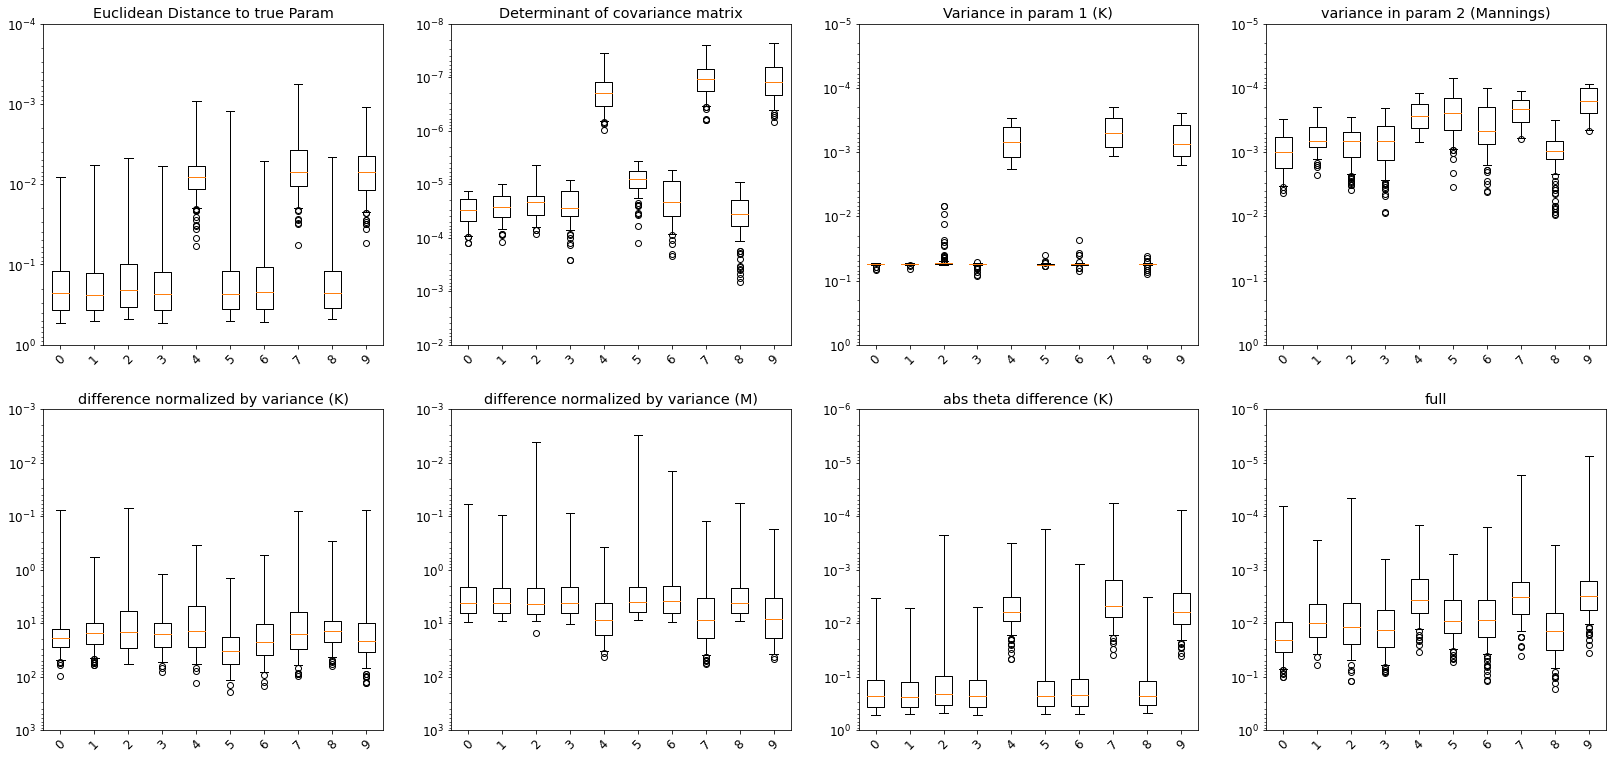

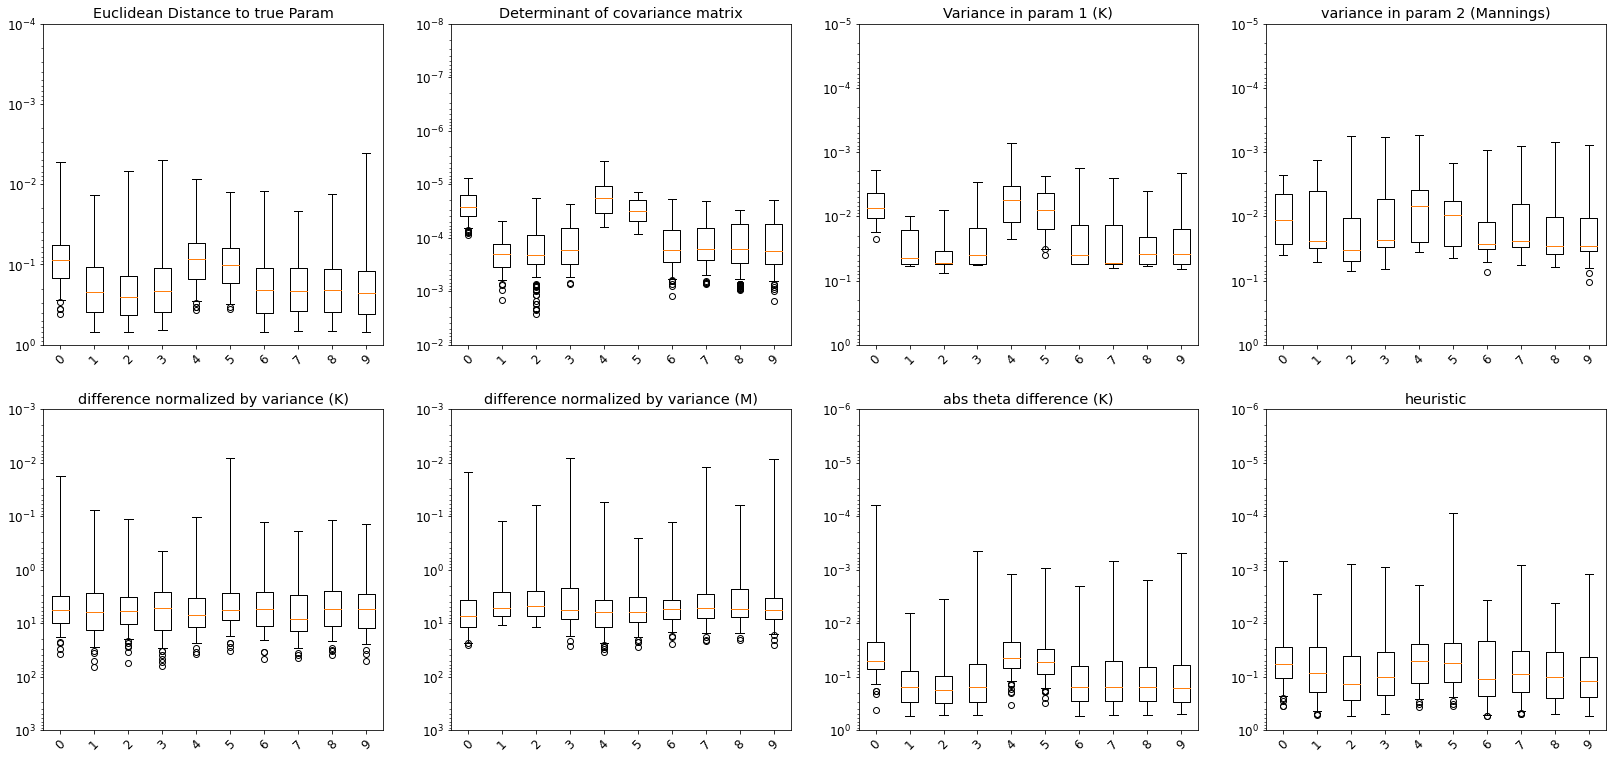

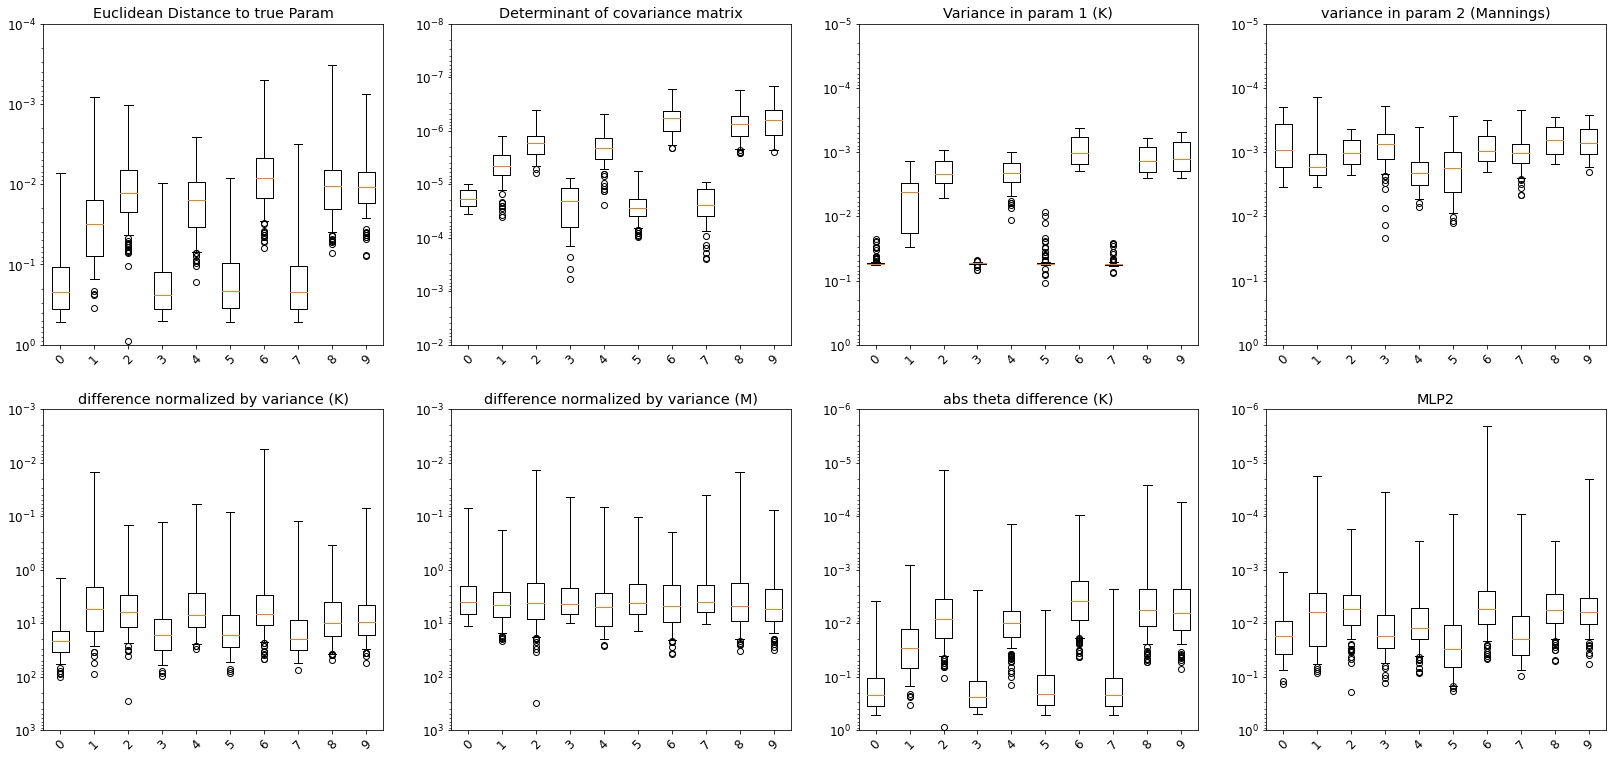

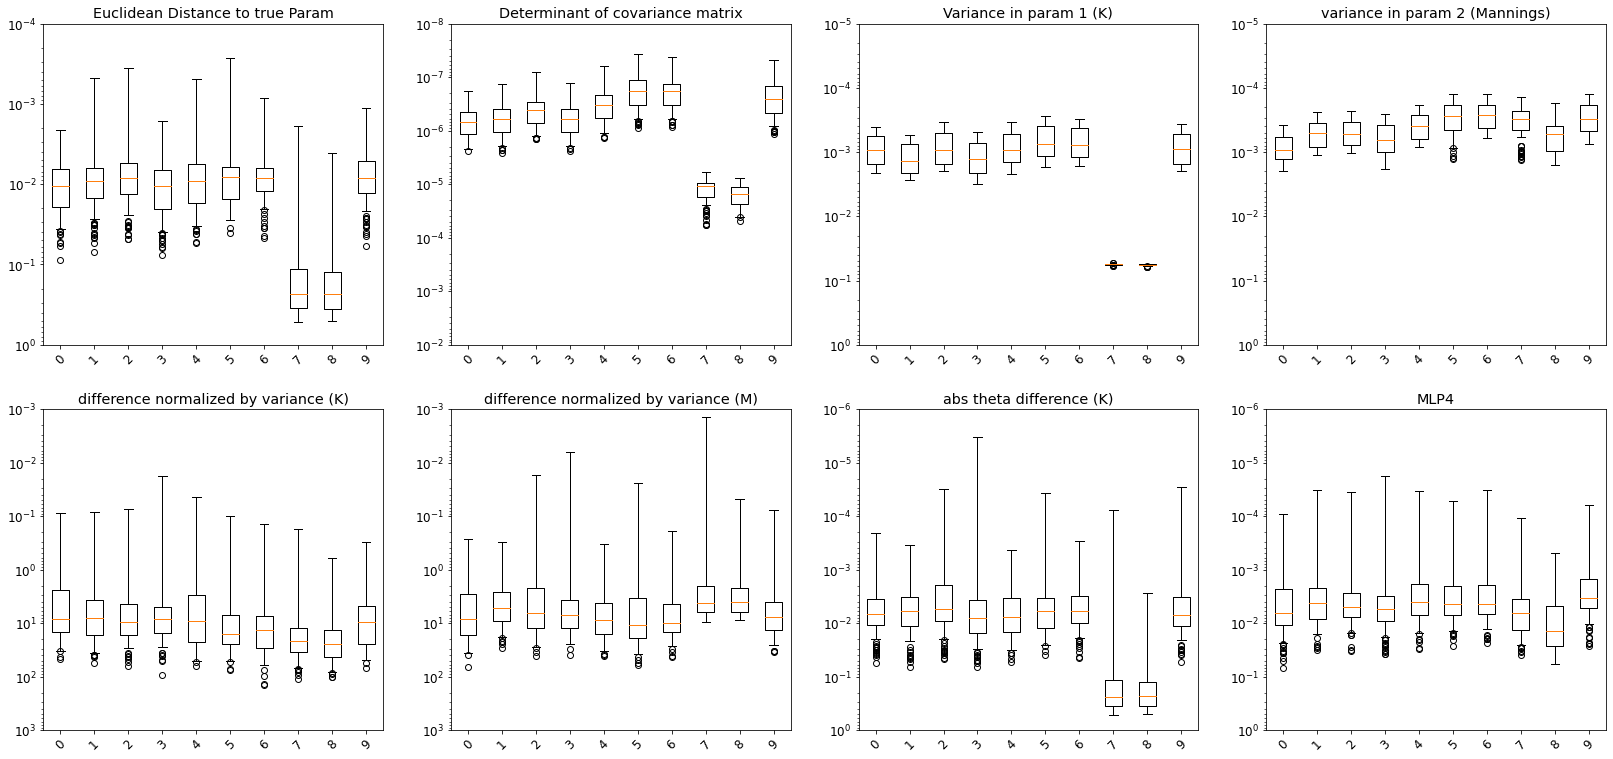

IndexError: index 4 is out of bounds for axis 2 with size 4

In [28]:
# new out_arr for bulk
new_out_arr = mknewdir(out_arr, sub_num)
name_list = [0,1,2,3,4,5,6,7,8,9]

plt.rc('font', size=12)

# loop through all of the bars
for idx in range(out_arr.shape[2]):
    temp_out_arr = out_arr[:,:,idx,:]
    bar_name = label_list[idx]
    plt_box_all(temp_out_arr, name_list, save_dir, bar_name=bar_name, save_bool=True)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


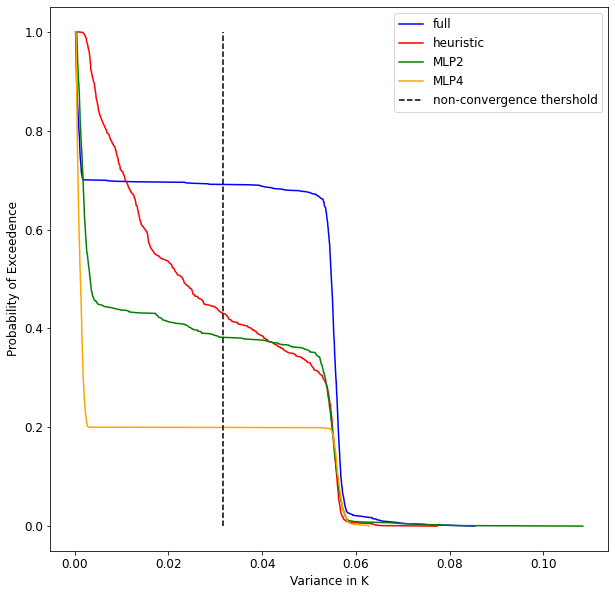

In [52]:
# assess the number of non-converge
new_out_arr_c = deepcopy(new_out_arr)

MOC = 1 #1=varK # metric of concern, index

fig, ax = plt.subplots(figsize=(10,10))

for idx in range(new_out_arr_c.shape[1]):
    bar_name = label_list[idx]
    temp_out_arr = np.sort(new_out_arr_c[:,idx,MOC])[::-1]
    temp_out_arr_p = np.linspace(0,1,len(temp_out_arr))
    col = col_list[idx]
    ax.plot(temp_out_arr, temp_out_arr_p, color=col, label=bar_name)

ax.plot([10**-(1.5), 10**-(1.5)], [0, 1], color='black', linestyle='dashed', label='non-convergence thershold')
ax.set_xlabel('Variance in K')
# ax.set_xlim(1e-4, 1e-1)
# ax.set_xscale('log')
ax.set_ylabel('Probability of Exceedence')
plt.legend()
if save_bool:
    fig.savefig(f'{save_dir}prob_exceedence_{MOC}.png')
    fig.savefig(f'{save_dir}prob_exceedence_{MOC}.eps', format='eps')

plt.show()
plt.close()



In [19]:
with open(f"{save_dir}new_out_arr.pkl", "wb") as handle:
    pickle.dump(new_out_arr, handle)

with open(f'{save_dir}cols_out_dir.txt', 'w') as file:
    books = [metrics_L]
    file.writelines("% s\n" % data for data in books)

with open(f'{save_dir}sbi_dir_list.txt', 'w') as file:
    books = [sbi_dir_list]
    file.writelines("% s\n" % data for data in books)

In [38]:
# truncated to extract only the best
label_list = ['full', 'heuristic', 'MLP2', 'MLP4']
idx_array = [9,        4,           9,       5]

# loop through all of the bars
trunc_out_arr = np.empty((100,len(idx_array),8))
for idx in range(out_arr.shape[2]):
    idx_run = idx_array[idx]
    trunc_temp_arr = out_arr[:,idx_run,idx,:]
    trunc_out_arr[:,idx,:] = trunc_temp_arr 
    del trunc_temp_arr, idx_run


plt_box_all(trunc_out_arr, label_list, save_dir, bar_name='best_all', save_bool=True)

NameError: name 'out_arr' is not defined

### Compare a single results

In [17]:
# truncated to extract only the best

label_list = ['heuristic', 'MLP2', 'MLP4', 'full']
sub_array = [4,             9,         5,     9]

# label_list = ['full', 'heuristic', 'MLP2', 'MLP4']
# sub_array = [9,        4,           9,       5]
sub_sub_int = 0

savename = '0819_01_mod2_10_13_log_mod_1107_01_xxxx_onelstm_0_raw'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/{savename}/'
bar_name = 'Comparison_Parameter_Bootstrap_at_Obs_00'
save_bool = True
plot_bool = False

sbi_dir_list = ['/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_[ 9 10]_onelstm_0_raw/',
                '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_embed_MLP_2_onelstm_0_raw/',
                '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_embed_MLP_4_onelstm_0_raw/',
                '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_10_13_log_mod_1107_01_full_onelstm_0_raw/']

# loop through all of the bars
    # len of outputs, number of things to track, len of models
trunc_out_arr = np.empty((50,4,len(sbi_dir_list)))
for idx in range(len(sbi_dir_list)):
#     print(idx)
    idx_start, idx_end = 0, 50
    sbi_dir = sbi_dir_list[idx]
    sub = sub_array[idx]
    
    # get out simulations
    y_sims, y_hat_plot, boots_params, boots_logprob = getData(sub, sub_sub_int, sbi_dir, ret_arrays=True)
    
    # get truth
    truth = getDataCov(sbi_dir, sub, sub_sub_int)['true param']
    print(truth)
    
    # compute NSE
    y_sims = y_sims.T
    y_sims_mean = np.mean(y_sims,axis=1)
    temp_metric_arr = getMetricArray(y_sims_T=y_sims, y_hat_plot=y_hat_plot)
    nse = temp_metric_arr[1,:]
    
    # get stuff in array
    trunc_out_arr[idx_start:idx_end, 0, idx] = nse
    trunc_out_arr[idx_start:idx_end, 1:3, idx] = boots_params
    trunc_out_arr[idx_start:idx_end, 3, idx] = boots_logprob[:,0]
    

[0.1931496 0.6102907]
[0.1931496 0.6102907]
[0.1931496 0.6102907]
[0.1931496 0.6102907]


In [22]:
def plt_box_single(in_arr, label_list, truth, save_dir, bar_name='', save_bool=True):
    '''
    Makes a box plot from the information in an array containing arrays of parameters etc.. for single observation
    
    returns:
        None
    '''
    fig, axs = plt.subplots(2, 2, figsize=(13,13))

    medianprops = dict(linestyle='-', linewidth=2.5, color='yellow')    
    boxprops = dict(linestyle='-', linewidth=1, color='blue')
    whiskerprops = dict(linestyle='-', linewidth=1, color='blue')
    
    axs[0,0].set_title('NSE of Streamflow from Inferred Parameters')
    axs[0,0].boxplot(in_arr[:,0,:], medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops)
#     axs[0,0].set_yscale('log')
    
    axs[0,1].set_title('Log probability of inferred parameters')
    axs[0,1].boxplot(in_arr[:,-1,:], medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops)
    
    axs[1,0].set_title('Distribution of Inferred Parameters (1)')
    axs[1,0].boxplot(in_arr[:,1,:], medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops)
    axs[1,0].plot([0,5],[truth[0],truth[0]] ,color='red', linestyle='--', alpha=0.8)

    axs[1,1].set_title('Distribution of Inferred Parameters (2)')
    axs[1,1].boxplot(in_arr[:,2,:], medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops)
    axs[1,1].plot([0,5],[truth[1],truth[1]] ,color='red', linestyle='--', alpha=0.8)

    y_lim_arr = np.array( [ [ [-0.1, 1.1], [0, 7] ]
                           ,[ [0, 1], [0, 1] ] ] )
    
    x_lim_arr = np.array([0.5, 4.5])

    for j in range(2):
        for k in range(2):
            y_lim_temp = y_lim_arr[j, k]
            axs[j, k].set_xticklabels(label_list, rotation=45)

            axs[j, k].set_ylim(y_lim_temp[0], y_lim_temp[1])
            axs[j, k].set_xlim(x_lim_arr[0], x_lim_arr[1])
            

    if save_bool:
        fig.savefig(f'{save_dir}bar_relation_{bar_name}.png')
        fig.savefig(f'{save_dir}bar_relation_{bar_name}.eps', format='eps')
    
    fig.suptitle(bar_name)
    plt.show()
    plt.close()
    
    return None

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


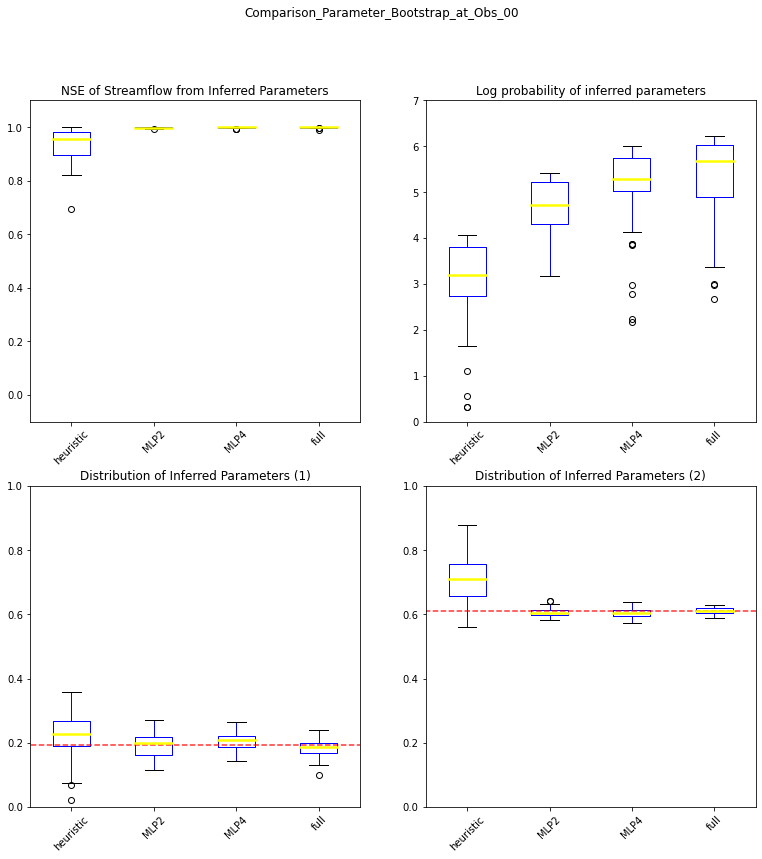

In [23]:
plt_box_single(in_arr=trunc_out_arr, label_list=label_list, truth=truth, save_dir=save_dir, bar_name=bar_name, save_bool=True)

### Single Ensemble Plot Hydrograph

In [9]:
sub = 9
sub_sub_num = 100

sbi_run  = '0819_01_mod2_10_13_log_mod_1107_01_full_onelstm_0_raw'
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/{sbi_run}/'
save_bool = True
trueflow = True
true_flow_idx = 82

stats_bool = True
stat_typ = np.array([1, 9, 10])
# for plotting
dim1, dim2 = 10, 10


plt.rc('font', size=10)

# plot_hydrograph(save_dir, sub, sub_sub_num, dim1, dim2, trueflow, true_flow_idx, scaled_bool=True, save_bool=True)

### Generate 2D Surface

In [10]:
out = getData_Surface(save_dir, sub, sub_sub_num, stats_bool=stats_bool,
                      stat_typ=stat_typ, scaled_bool=True, save_bool=True)

# out = getData_Surface(save_dir, sub, sub_sub_num, scaled_bool=True, save_bool=True)

In [11]:
print(out['stat_arr'][:,0].min())
print(out['stat_arr'][:,0].max())

0.04020699858665466
0.15657052397727966


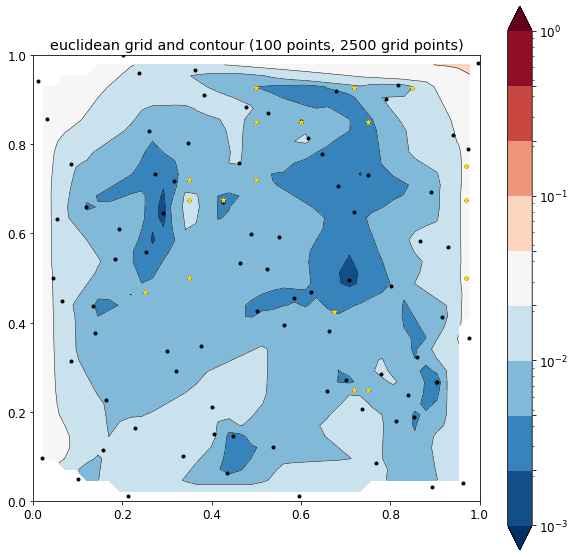

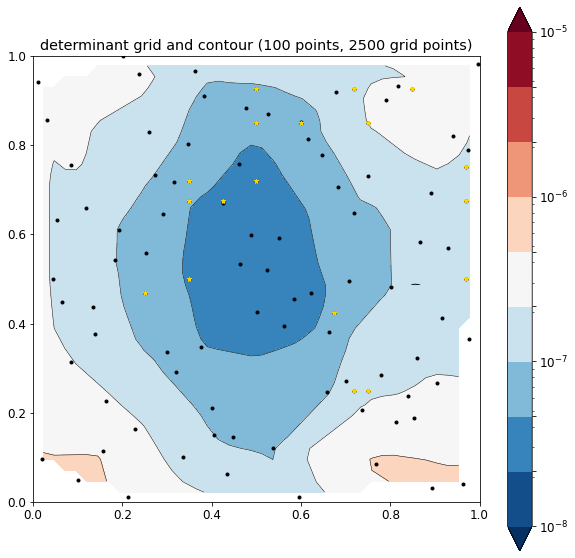

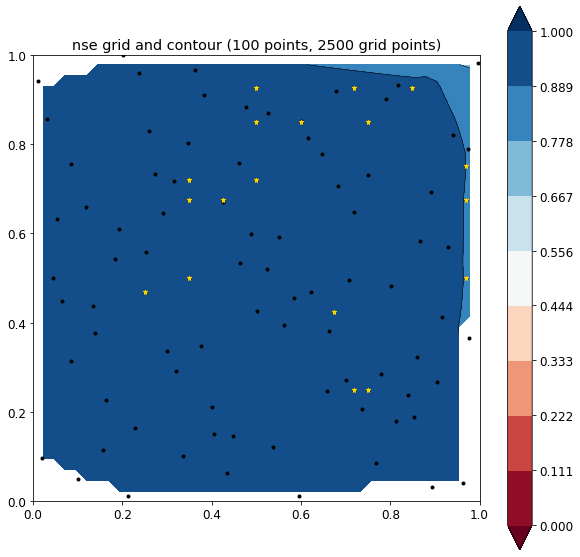

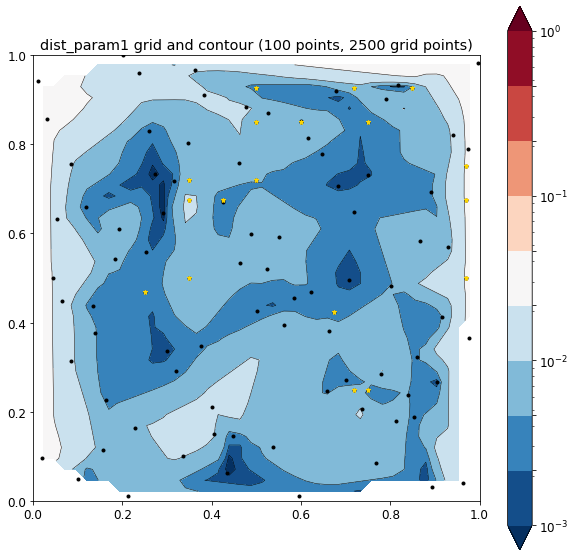

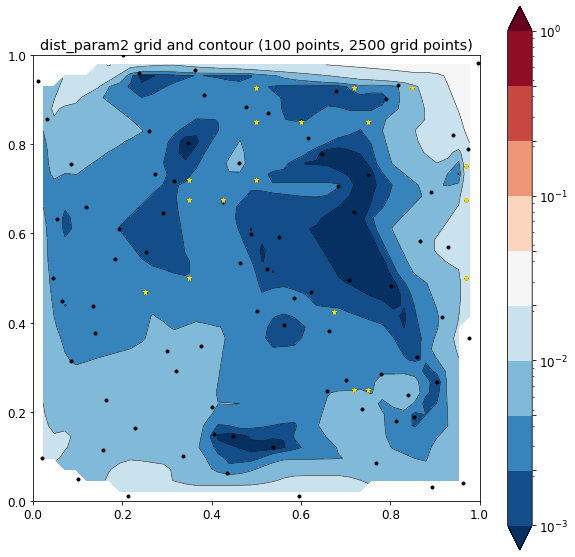

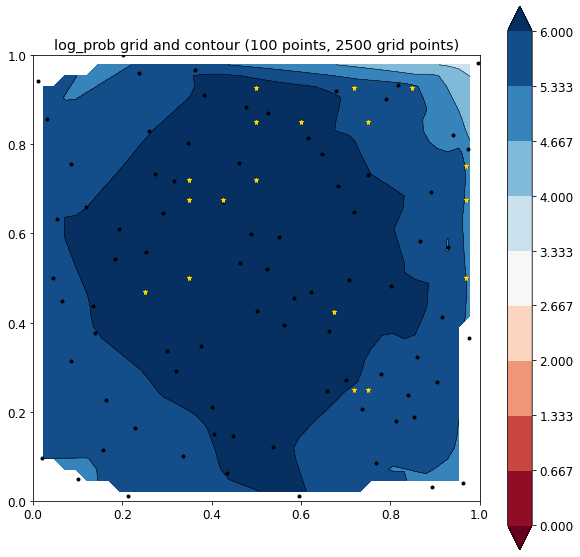

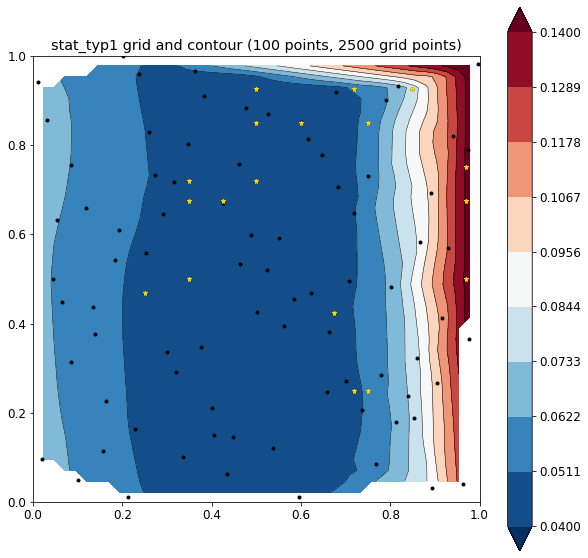

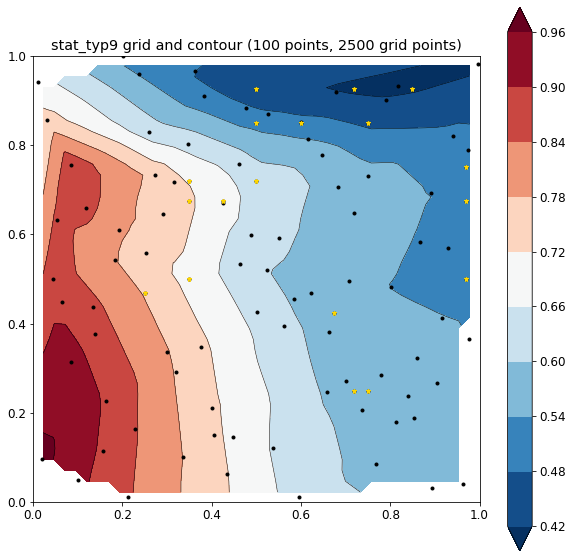

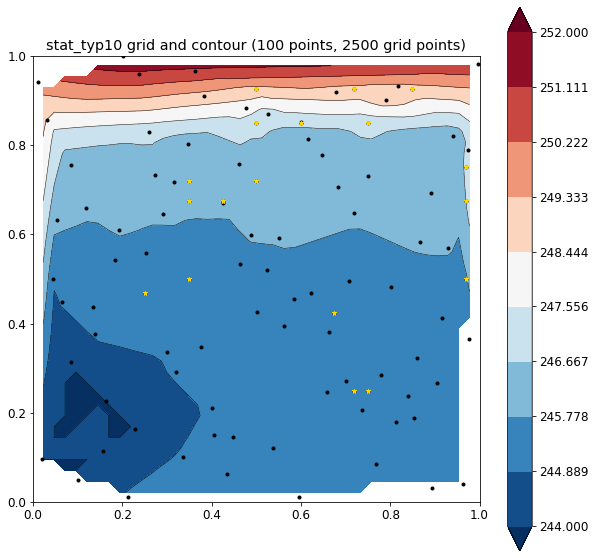

In [12]:
# plottage
ngrid = 50
levels = 10

cmap = "RdBu" #__r
param_arr = out['param_arr']
cmap_list = ["RdBu_r", "RdBu_r", "RdBu", "RdBu_r", "RdBu_r", "RdBu" , "RdBu_r", "RdBu_r", "RdBu_r"]
norm_list = [True, True, False, True, True, False, False, False, False]
z_name_list = ['euclidean', 'determinant', 'nse', 'dist_param1', 'dist_param2',
                'log_prob', f'stat_typ{stat_typ[0]}', f'stat_typ{stat_typ[1]}', f'stat_typ{stat_typ[2]}']

z_arr_list = [out['euc_arr'], out['det_arr'], out['nse_arr'], out['dist_arr'][:,0], out['dist_arr'][:,1], 
              out['prob_arr'], out['stat_arr'][:,0], out['stat_arr'][:,1], out['stat_arr'][:,2]]

levels_list = {'determinant' : np.exp(np.linspace(np.log(1e-8),np.log(1e-5),levels)), 
               'dist_param1' : np.exp(np.linspace(np.log(1e-3),np.log(1e-0),levels)), 
               'dist_param2' : np.exp(np.linspace(np.log(1e-3),np.log(1e-0),levels)), 
               'euclidean'   : np.exp(np.linspace(np.log(1e-3),np.log(1e-0),levels)), 
               'log_prob'    : np.linspace(0,6,levels),
               'nse'         : np.linspace(0,1,levels),
               f'stat_typ{stat_typ[0]}' : np.linspace(0.04,0.14,levels), # np.linspace(0.04,0.14,levels)
               f'stat_typ{stat_typ[1]}' : np.linspace(0.42,0.96,levels), # np.linspace(0.42,0.96,levels)
               f'stat_typ{stat_typ[2]}' : np.linspace(244,252,levels) # np.linspace(259,266,levels)
              }

plt.rc('font', size=12)

for idx_out in range(len(z_arr_list)):
    z_name = z_name_list[idx_out]
    if levels_list is None:
        levels_arr = levels
    else:
        levels_arr = levels_list[z_name]
    gen_2D_surface(z_name, z_arr_list[idx_out], param_arr, 
                   save_dir, sub, trueflow=trueflow, true_flow_idx=true_flow_idx, 
                   ngrid=ngrid, levels=levels_arr, norm_bool=norm_list[idx_out], cmap=cmap_list[idx_out], save_bool=True)

In [50]:
# # min-max of forcings / streamflow
# min_label_list, max_label_list = _ret_MinMax(labelist, df_l)
# scale_l, trans_l = scaled_ens_Values(min_label_list, max_label_list, dist_range=[0,1])
# # min-max of AOCs 
# min_AOC_list, max_AOC_list = _ret_AOCMinMax(AOC_ens_l)
# scale_AOC, trans_AOC = scaled_ens_Values(min_AOC_list, max_AOC_list, dist_range=[0,1])

# # transform based on min-max info [function]
# # scale forcings / streamflow
# df_l_scaled = scaledForcingData(scale_l, df_l)
# AOC_ens_scale_l = scaledAOCData(scale_AOC, AOC_ens_l)

### Reading in Parflow Truths and running inference on ParFlow truths

In [22]:
sub = 4
idx = 3 #PF:LSTM, 0=82, 1=83, ....

n_samples = 5000 
stat_method = 'full'#   stat_method = 'summary', 'full', 'embed'
stat_typ = None # np.array([9,10])  # np.array([1,3,4,5,7,9,10,11])   # np.array([9,10]) # np.array([9,10]) #   use arrays for multiple parameters np.array([9,10])
out_dim = None # 2 # number of dimensions for ML
embed_type = None # 'MLP' # 'MLP', 'CNN', 'RNN'
stat_typ = retStatTyp(stat_method, stat_typ=stat_typ, out_dim=out_dim, embed_type=embed_type)

sbi_run  = f'0819_01_mod2_10_13_log_mod_1107_01_{stat_typ}_onelstm_0_raw'
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/{sbi_run}/'
sbi_dir_sub = f'{sbi_dir}{sub}/'

lstm_name = '10_13_log_mod'
lstm_path = f'/home/qh8373/SBI_TAYLOR/data/04_lstm_out/{lstm_name}/'

# load lstm info
with open(lstm_path+'list_df_cond.pkl', 'rb') as fp:
    list_df_cond = pickle.load(fp)

# load posterior
with open(sbi_dir_sub+'posterior.pkl', 'rb') as fp:
            posterior = pickle.load(fp)



/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)



tensor([0.2500, 0.4688])


<ipython-input-23-ab65ce62deec>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),


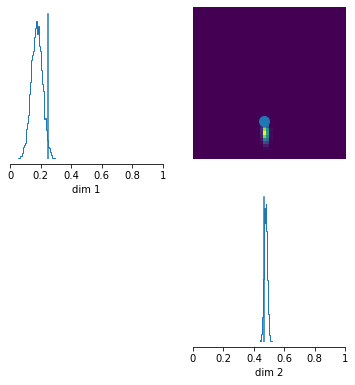

In [23]:
# load observation (from ParFlow)
'''
ParFlow truth loads
lstm_df_cond should be loaded
to test ParFlow truths on models trained with LSTMs and previous tested with LSTM synthetic truths
'''

DataX_test, DataY_test, series_len, lstm_out_list = parseListDf(list_df_cond)
test_params, num_params, num_unique, DataX_test = parseUniqueParams(DataX_test, series_len)

unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method, stat_typ=stat_typ, embed_type=embed_type)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)

'''
sample observation (y_hat) and 'correct' parameter (true_theta)
    y_hat_full is the full timeseries (important for embed and summary stat method)
'''
y_hat = unique_series_PF[idx]
y_hat_full = unique_series_full_PF[idx]
true_theta = test_params[idx]

'''
sample posterior and create log probability
'''
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples = posterior.sample((n_samples,), x=y_hat) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability = posterior.log_prob(posterior_samples, x=y_hat).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print(true_theta)
fig, axes = analysis.pairplot(posterior_samples, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 